In [1]:
import os

import geopandas
import contextily as cx
from geodatasets import get_path
import matplotlib.pyplot as plt
import dask.dataframe as dd


from bigdata.augmentation_utils import read_data

FILE_PATH = os.getcwd()
ROOT_DIR = FILE_PATH.split("src")[0]
DATA_DIR = ROOT_DIR + "data"

In [2]:
# Load the school data
school_data = read_data(
    os.path.join(DATA_DIR, "csv", "raw", f"school_locations.csv"),
    format="csv",
    dtype={
        "HighSchool_Network_Location_Code": "object",
        "HighSchool_Network_Name": "object",
        "HighSchool_Network_Superintendent": "object",
    },
    assume_missing=True,
)

# Convert dates
school_data["open_date"] = dd.to_datetime(school_data["open_date"], errors="coerce")
school_data = school_data.dropna(subset=["open_date", "LONGITUDE", "LATITUDE"])

# Filter closed schools
school_data["Status_descriptions"] = school_data["Status_descriptions"].fillna(
    "Open"
)
school_data = school_data[school_data["Status_descriptions"] == "Open"]
school_data = school_data.drop(columns=["Status_descriptions"])
school_data = school_data[
    ["open_date", "LONGITUDE", "LATITUDE", "Location_Category_Description"]
]

boroughs = geopandas.read_file(get_path("nybb")).to_crs(epsg=4326)

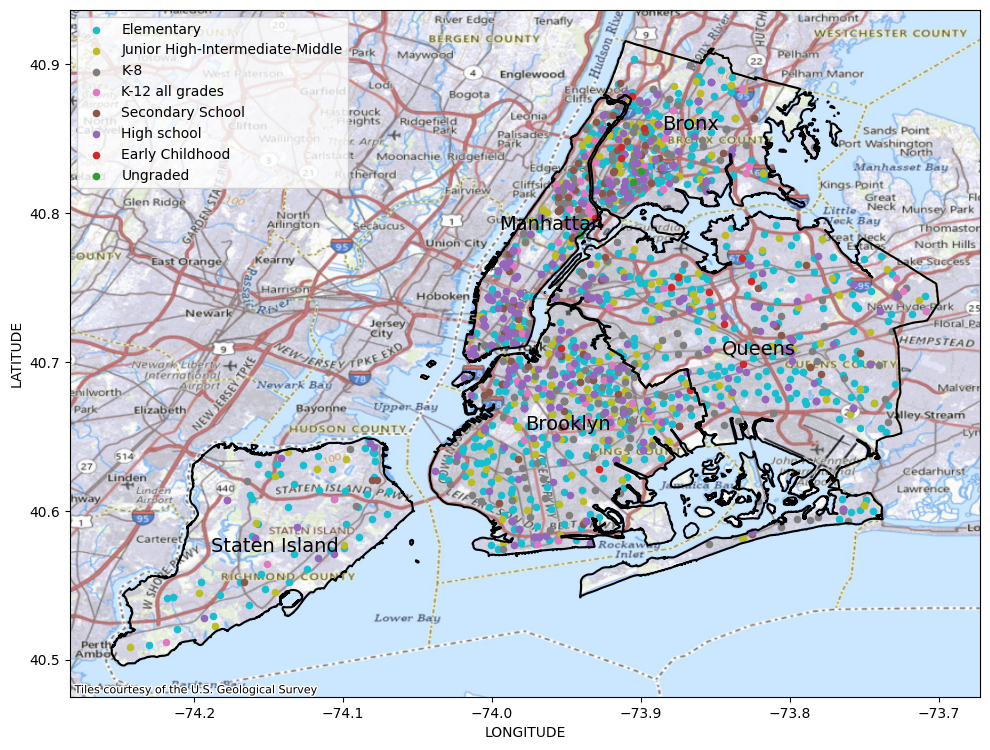

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
boroughs.boundary.plot(ax=ax, color="black")

for i, row in boroughs.iterrows():
    ax.annotate(
        row["BoroName"],
        xy=row["geometry"].representative_point().coords[0],
        ha="center",
        color="black",
        fontsize=14,
    )

colors = list(plt.get_cmap("tab10").colors)
categories = school_data["Location_Category_Description"].compute()
for category in categories.unique():
    school_data.compute()[categories == category].plot.scatter(
        x="LONGITUDE",
        y="LATITUDE",
        ax=ax,
        color=colors.pop(),
        label=category,
    )

ax.legend(loc="upper left")
cx.add_basemap(ax, crs=boroughs.crs, source=cx.providers.USGS.USTopo)
fig.tight_layout()
plt.savefig("../../T3_figures/schools.png")